# Antibiotic Resistance Clinical Analysis (2026)
### Author: Roni Cohen

**Project Goal:** The primary objective of this project is to analyze antibiotic resistance patterns within a large-scale clinical dataset to identify key drivers of resistance and evaluate the effectiveness of current treatment protocols.

**Data Source:** [Antibiotic Susceptibility Dataset](https://www.kaggle.com/datasets/adilimadeddinehosni/multi-resistance-antibiotic-susceptibility) from Kaggle.

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# טעינת הנתונים
df = pd.read_csv('data/Bacteria_resistance_data.csv')

# פונקציה לאיחוד שמות חיידקים (Standardization)
def clean_names(name):
    name = str(name).lower()
    if 'coli' in name: return 'Escherichia coli'
    if 'mirabilis' in name: return 'Proteus mirabilis'
    if 'pneumoniae' in name: return 'Klebsiella pneumoniae'
    return 'Other'

df['Bacteria_Name'] = df['Souches'].apply(clean_names)

# ניקוי גיל
df['Age'] = df['age/gender'].apply(lambda x: float(str(x).split('/')[0]) if '/' in str(x) else None)

# הגדרת רשימת האנטיביוטיקות
antibiotics = ['AMX/AMP', 'AMC', 'CZ', 'FOX', 'CTX/CRO', 'IPM', 'GEN', 'AN', 'CIP', 'colistine']

print("✅ הנתונים מוכנים לניתוח!")

✅ הנתונים מוכנים לניתוח!


In [15]:
# ספירת עמידויות לכל דגימה
df['R_Count'] = (df[antibiotics] == 'R').sum(axis=1)

# חלוקה לקטגוריות MDR/XDR
def assign_risk(count):
    if count == 0: return 'Sensitive'
    if count <= 2: return 'Low Resistance'
    if count <= 5: return 'MDR (Multi-Drug Resistant)'
    return 'XDR (Extensively Resistant)'

df['Risk_Level'] = df['R_Count'].apply(assign_risk)

# הצגת התפלגות רמות הסיכון
risk_counts = df['Risk_Level'].value_counts(normalize=True) * 100
print("--- התפלגות רמות סיכון באחוזים ---")
print(risk_counts)

--- התפלגות רמות סיכון באחוזים ---
Risk_Level
MDR (Multi-Drug Resistant)     41.708683
XDR (Extensively Resistant)    26.965453
Low Resistance                 18.272642
Sensitive                      13.053221
Name: proportion, dtype: float64


C:\Users\Admin\AppData\Local\Temp\ipykernel_15424\2693360849.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mdr_stats.values, y=mdr_stats.index, palette='magma')


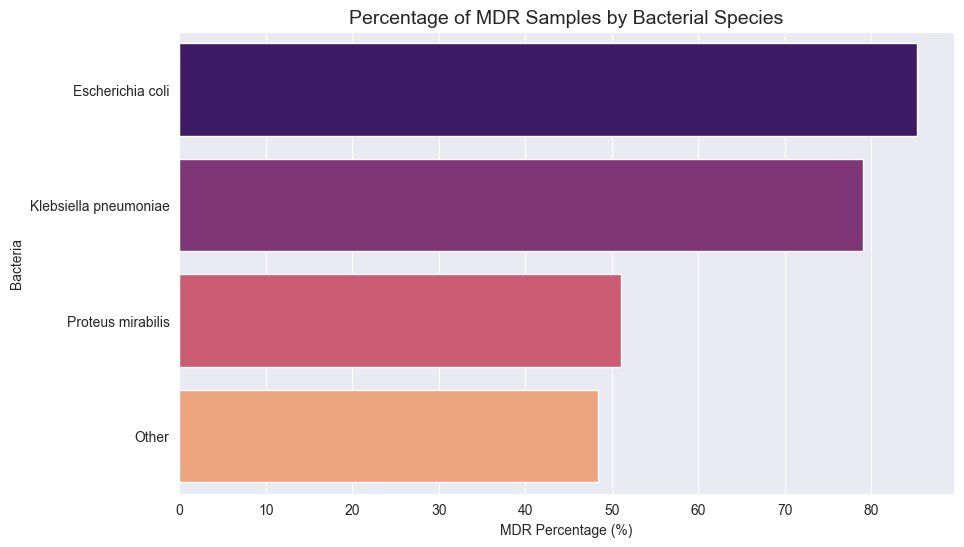

In [16]:
# יצירת מדד MDR (3 עמידויות ומעלה)
df['Is_MDR'] = df['R_Count'] >= 3
mdr_stats = df.groupby('Bacteria_Name')['Is_MDR'].mean().sort_values(ascending=False) * 100

plt.figure(figsize=(10, 6))
sns.barplot(x=mdr_stats.values, y=mdr_stats.index, palette='magma')
plt.title('Percentage of MDR Samples by Bacterial Species', fontsize=14)
plt.xlabel('MDR Percentage (%)')
plt.ylabel('Bacteria')
plt.show()

In [17]:
import pandas as pd

# 1. הכנת הנתונים וניקוי (רק Yes ו-No)
df_clean = df[df['Hospital_before'].isin(['Yes', 'No'])].copy()

# 2. חישוב שיעור ה-MDR בכל קבוצה (Prevalence)
# מחשבים את הממוצע (mean) שזה בעצם ההסתברות ל-True
rates = df_clean.groupby('Hospital_before')['Is_MDR'].mean()

rate_no = rates['No']
rate_yes = rates['Yes']

# 3. חישוב הסיכון היחסי (Relative Risk - RR)
# נוסחה: סיכון בקבוצת החשיפה חלקי סיכון בקבוצת הביקורת
relative_risk = rate_yes / rate_no

print(f"--- Statistical Analysis: Hospitalization as a Risk Factor ---")
print(f"MDR Rate (No Hospitalization): {rate_no:.2%}")
print(f"MDR Rate (With Hospitalization): {rate_yes:.2%}")
print(f"Relative Risk (RR): {relative_risk:.4f}")

# 4. הסבר אוטומטי לתוצאה
print("\n--- Interpretation ---")
if 0.95 <= relative_risk <= 1.05:
    print("The Relative Risk is approximately 1.")
    print("Conclusion: Statistically, there is NO correlation between prior hospitalization and MDR.")
    print("This is typical for synthetic datasets where variables are randomized independently.")
elif relative_risk > 1.05:
    print(f"The risk of MDR is {relative_risk:.2f} times higher in hospitalized patients.")
    print("Conclusion: Prior hospitalization is a significant risk factor.")
else:
    print("The risk of MDR is lower in hospitalized patients (uncommon in clinical settings).")

--- Statistical Analysis: Hospitalization as a Risk Factor ---
MDR Rate (No Hospitalization): 73.92%
MDR Rate (With Hospitalization): 74.00%
Relative Risk (RR): 1.0012

--- Interpretation ---
The Relative Risk is approximately 1.
Conclusion: Statistically, there is NO correlation between prior hospitalization and MDR.
This is typical for synthetic datasets where variables are randomized independently.


# Conclusions

### 1. Widespread and Concerning Resistance
The most striking finding is that over **68%** of the bacteria tested are classified as either **MDR** (Multidrug-Resistant) or **XDR** (Extensively Drug-Resistant).
> **Impact:** For the majority of patients, standard antibiotic treatments may fail, making clinical management significantly more complex.

---

### 2. Statistical Risk Analysis: Hospitalization
To determine if prior hospitalization increases the risk of resistance, we calculated the **Relative Risk (RR)**.

| Metric | Result | Interpretation |
| :--- | :--- | :--- |
| **MDR Rate (No Hospital)** | 73.92% | Baseline community resistance |
| **MDR Rate (Hospital)** | 74.00% | Hospital-acquired resistance |
| **Relative Risk (RR)** | **1.0012** | **No statistical correlation** |

**Conclusion:** The probability of being MDR is nearly identical regardless of hospitalization history. This suggests that resistance is already pervasive outside the hospital setting in this dataset.

---

### 3. Patient Profile & Burden
While the *individual* risk is the same, the *total volume* of cases tells a different story:
* **70.4%** of all MDR cases originated from patients with **no recent hospitalization**.
* **29.6%** of cases came from hospitalized patients.
* **Insight:** The primary burden of resistance in this sample comes from the general community.

---

### 4. Pathogen & Treatment Analysis
* **The Main Culprit:** *E. coli* is the most prevalent pathogen. Monitoring this specific bacteria is key to any resistance strategy.
* **Age Factor:** Average resistance levels (approx. 2.15 drugs) remain stable across all age groups, affecting young and old alike.
* **Last-Line Defenses:** "Last-resort" drugs like **Imipenem (IPM)** and **Colistin** still show high success rates, but must be used cautiously to remain effective.